In [18]:
import torch
import json
import torchvision
import shutil
import os
import ultralytics
from matplotlib import pyplot as plt, patches

In [3]:
yolo = ultralytics.YOLO("yolov8m.pt")

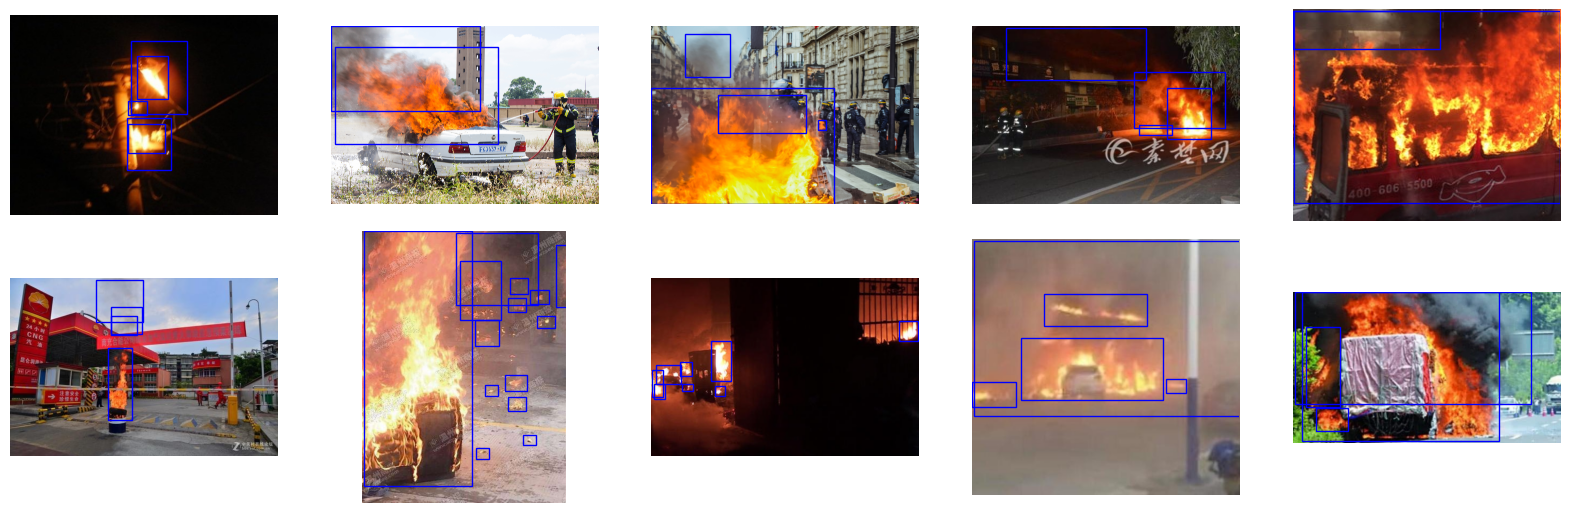

In [4]:
with open('./data/475_fire_train/annotations/instances_default.json', 'r') as f:
    data = json.load(f)

    row = 1

    plt.figure(figsize=(20, 12))

    for index, image_data in enumerate(data['images'][:10]):
        if index % 5 == 0:
            row += 1

        image = torchvision.io.read_image(
            os.path.join('data', '475_fire_train', 'images', image_data['file_name'])
        )
        image = image.permute(1, 2, 0)

        ax = plt.subplot(row, 5, index + 1)

        annotations = [a for a in data['annotations'] if a['image_id'] == image_data['id'] and a['category_id'] in (4, 5)]

        for annotation in annotations:
            x, y, w, h = annotation['bbox']
            patch = patches.Rectangle(
                (x, y), w, h,
                linewidth=1,
                edgecolor='b',
                facecolor='none',
            )
            ax.add_patch(patch)

        ax.axis('off')
        ax.imshow(image)
        

    plt.show()  

In [ ]:
if not os.path.exists(os.path.join('converted_data', 'labels')):
    shutil.copytree('./data/475_fire_train/images/train', './converted_data/images/train')
    os.makedirs(os.path.join('converted_data', 'labels', 'train'))

with open('./data/475_fire_train/annotations/instances_default.json', 'r') as f:
    data = json.load(f)

    image_id_to_image = { image['id']: image for image in data['images'] }

    result = dict()

    for annotation in data['annotations']:
        # we are interested only in fire and smoke categories from the dataset
        if annotation['category_id'] != 4 and annotation['category_id'] != 5:
            continue
        
        image_id = annotation['image_id']
        image = image_id_to_image[image_id]
        image_w, image_h = image['width'], image['height']
        x, y, w, h = annotation['bbox']

        x = (x + w / 2) / image_w
        y = (y + h / 2) / image_h
        w = w / image_w
        h = h / image_h

        normalized_bbox = [x, y, w, h]

        result.setdefault(image_id, []).append([annotation['category_id'], *normalized_bbox])

    for image_id, annotations in result.items():
        image_name = image_id_to_image[image_id]['file_name']
        image_name = image_name.split('/')[1]
        image_name = image_name.split('.')[0]

        with open(os.path.join('converted_data', 'labels', 'train', f"{image_name}.txt"), 'a') as f:
            for annotation in annotations:
                f.write(' '.join(list(map(str, annotation)) + ['\n']))

